In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import zipfile

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/PlantVillage.zip")
# zip_ref.extractall("/content/drive/MyDrive/PlantVillage")
# zip_ref.close()

In [3]:
# data_dir = "/content/drive/MyDrive/PlantVillage/PlantVillage"

In [4]:
# import os

# for root, dirs, files in os.walk(data_dir):
#   print(f"There are {len(files)} files and {len(dirs)} directories in the {root}")

In [5]:
import tensorflow_datasets as tfds

(dataset,), info = tfds.load('plant_village', 
                    batch_size=32,
                    as_supervised=True,
                    shuffle_files=True,
                    with_info=True,
                    split=['train'],                    
          )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/plant_village/1.0.2.incompleteM84XKP/plant_village-train.tfrecord*...:   0…

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [6]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
#                                                               batch_size=32, 
#                                                               label_mode='categorical',
#                                                               image_size=(224, 224),
#                                                               seed=42,
                                                              
#                                                               )

In [7]:
len(dataset)

1697

In [8]:
class_names = info.features['label'].names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat

In [9]:
len(class_names)

38

In [10]:
for image, label in dataset.take(1):
  print(image.shape)
  print(label.numpy())

(32, 256, 256, 3)
[15 16 16  9 25  6 19 37  1 22 11 33 12  3 37 35 33 29 25 16 32 15 24 35
 37  6 12 15 18 30 15 32]


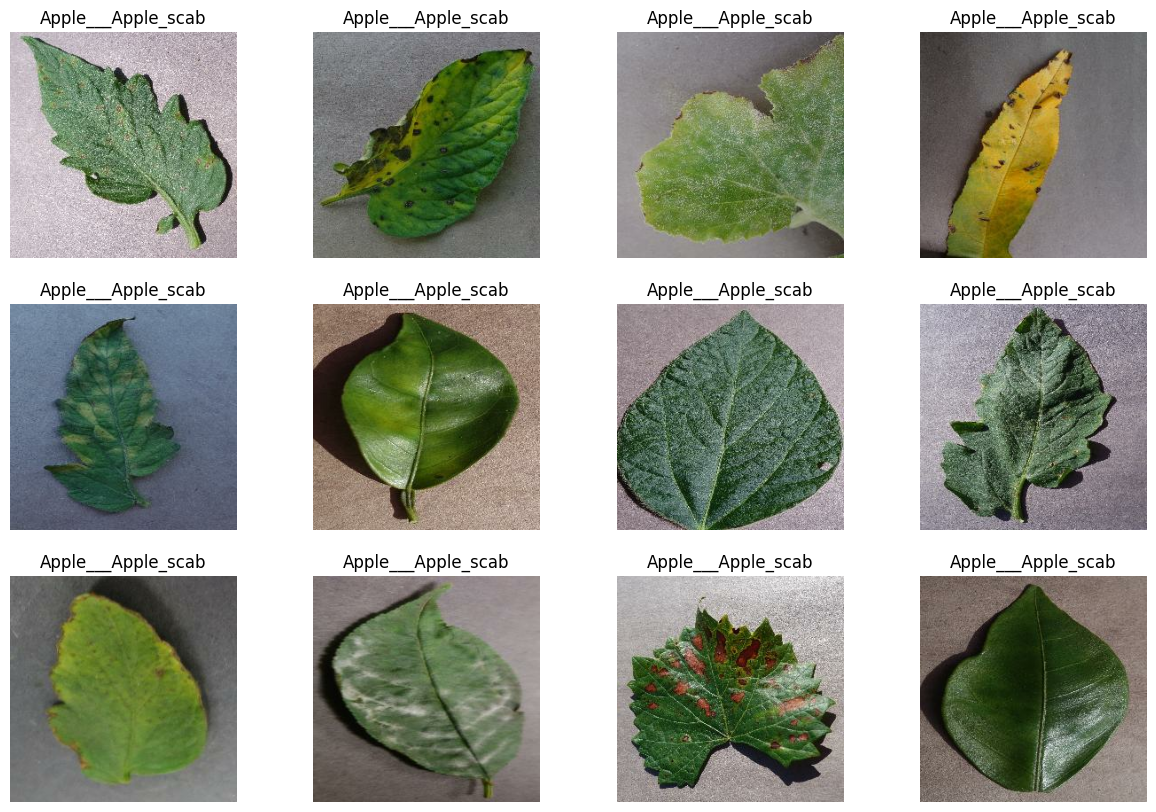

In [11]:
plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i].numpy().argmax()])
    plt.axis(False);

In [12]:
len(dataset)

1697

In [13]:
def split_dataset(dataset, train_split=0.8, test_split=0.1, val_split=0.1):
  ds_size = len(dataset)
  train_size = int(ds_size * train_split)
  val_size = int(ds_size * val_split)


  train_ds = dataset.take(train_size)

  val_ds = dataset.skip(train_size).take(val_size)

  test_ds = dataset.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [14]:
train_ds, val_ds, test_ds = split_dataset(dataset)


In [15]:
len(train_ds), len(val_ds), len(test_ds)

(1357, 169, 171)

In [16]:
for image, label in train_ds.take(1):
  print(image.shape)
  print(label)

(32, 256, 256, 3)
tf.Tensor(
[33 29 25 16 32 15 24 35 37  6 12 15 18 30 15 32 16 27  0 24 37  9 24  4
 30 31  1 31 28 37 11 28], shape=(32,), dtype=int64)


In [17]:
def resize_image(image, label):
  image = tf.image.resize(image, [224, 224])
  return image, label

In [18]:
train_ds = train_ds.map(resize_image).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_image).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.map(resize_image).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=3)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),

    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=100,
                    steps_per_epoch=len(train_ds),
                    validation_data=val_ds,
                    validation_steps=len(val_ds),
                    callbacks=[early_stopping])

Epoch 1/100
1357/1357 [==============================] - 105s 73ms/step - loss: 2.0512 - accuracy: 0.4325 - val_loss: 1.2735 - val_accuracy: 0.6191
Epoch 2/100
1357/1357 [==============================] - 109s 81ms/step - loss: 0.9113 - accuracy: 0.7225 - val_loss: 0.8216 - val_accuracy: 0.7432
Epoch 3/100
1357/1357 [==============================] - 111s 82ms/step - loss: 0.5973 - accuracy: 0.8122 - val_loss: 0.5705 - val_accuracy: 0.8184
Epoch 4/100
1357/1357 [==============================] - 96s 70ms/step - loss: 0.4582 - accuracy: 0.8526 - val_loss: 0.4427 - val_accuracy: 0.8606
Epoch 5/100
1357/1357 [==============================] - 97s 71ms/step - loss: 0.3638 - accuracy: 0.8814 - val_loss: 0.3808 - val_accuracy: 0.8835
Epoch 6/100
1357/1357 [==============================] - 96s 71ms/step - loss: 0.2992 - accuracy: 0.9017 - val_loss: 0.3917 - val_accuracy: 0.8746
Epoch 7/100
1357/1357 [==============================] - 108s 80ms/step - loss: 0.2575 - accuracy: 0.9141 - val_los

In [21]:

# import os

# file_path = '/content/drive/MyDrive/PlantVillage/PlantVillage/Pepper__bell___healthy/c6dfe386-62c3-464d-8815-2a6c08531d11___JR_HL 8538.JPG'

# if os.path.exists(file_path):
#     os.remove(file_path)
#     print(f"File {file_path} deleted successfully.")
# else:
#     print(f"File {file_path} does not exist.")

<Axes: >

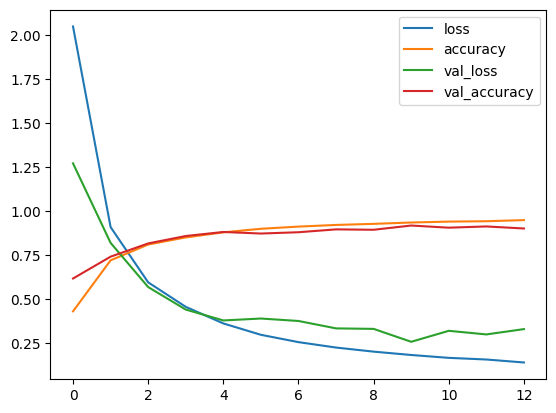

In [31]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [32]:
model.evaluate(test_ds)


169/169 [==============================] - 29s 45ms/step - loss: 0.3298 - accuracy: 0.9037


[0.329763799905777, 0.9036612510681152]

1/1 [==============================] - 0s 38ms/step


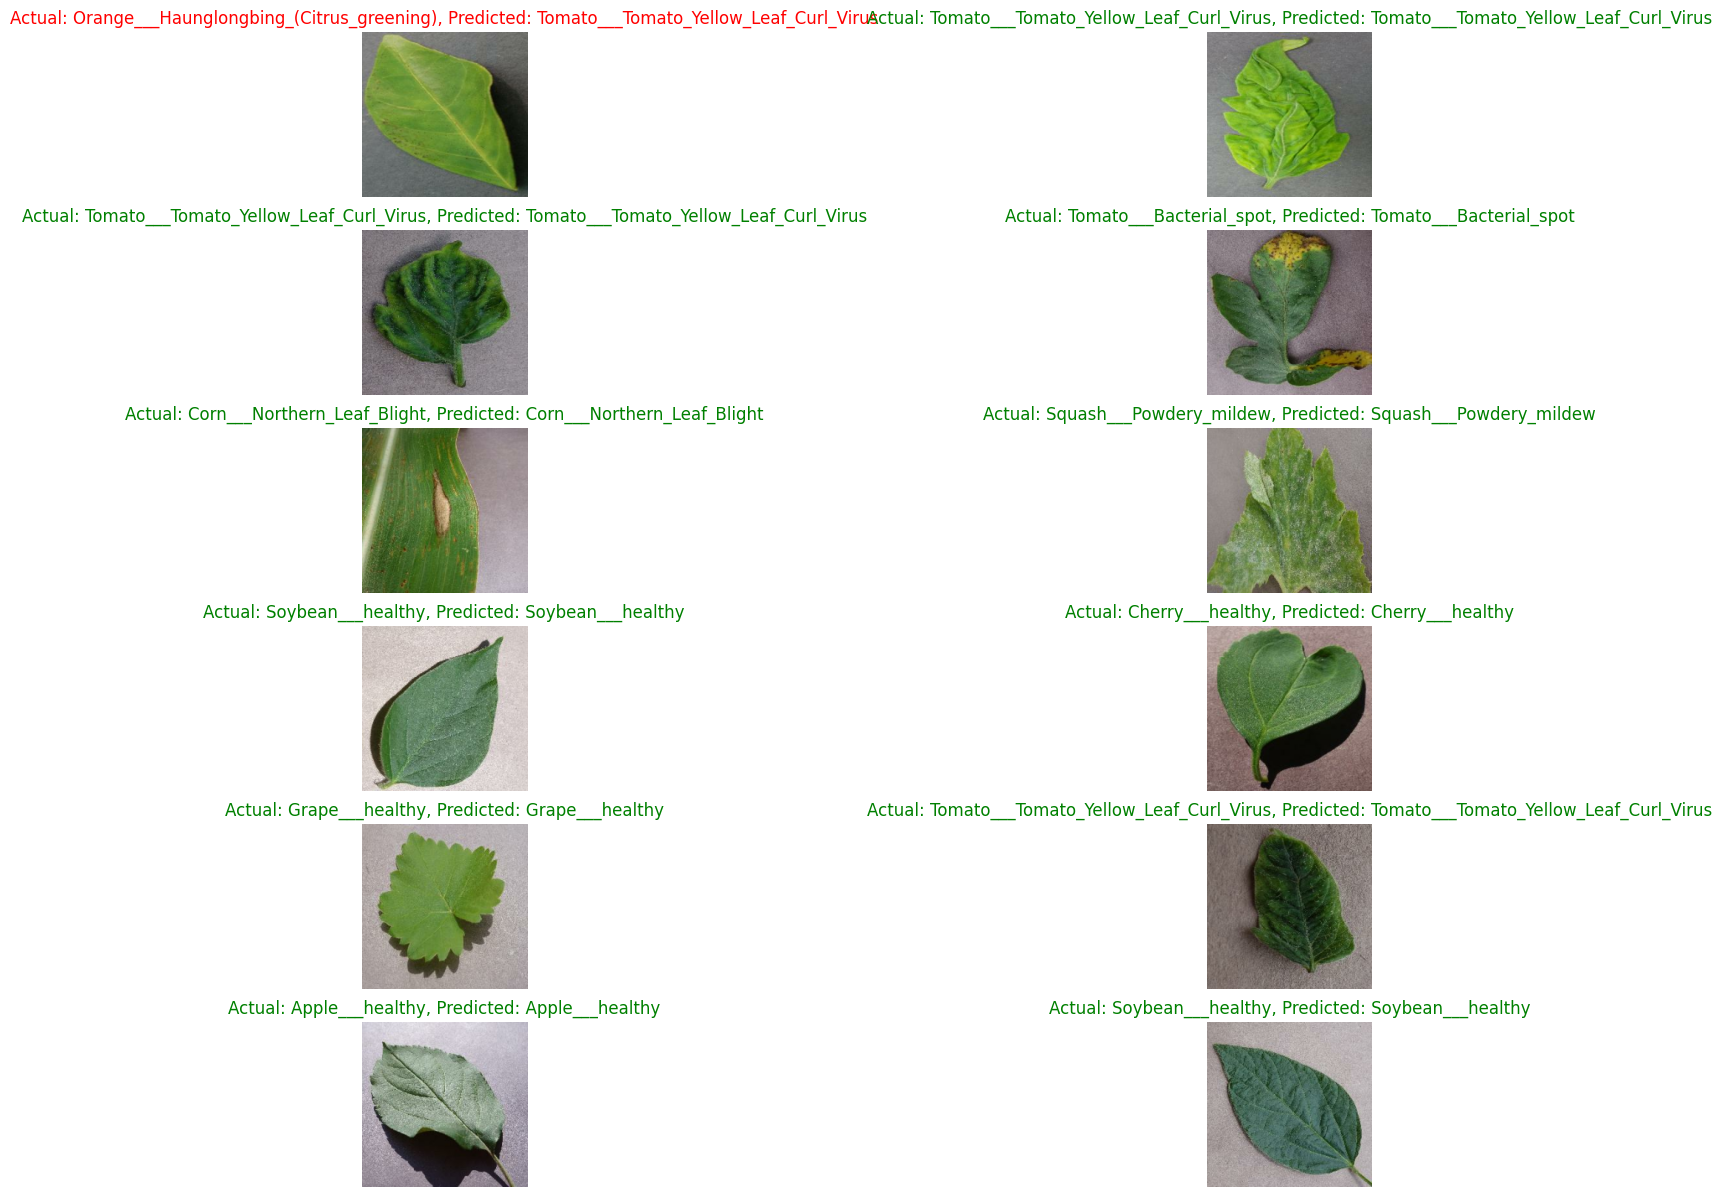

In [34]:
plt.figure(figsize=(20, 15))
for image_test, label_test in test_ds.take(1):
  for i in range(12):
    plt.subplot(6, 2, i+1)
    first_image = image_test[i].numpy().astype('uint8')
    first_label = label_test[i].numpy()

    actual_value = class_names[first_label]
  
    prediction = model.predict(tf.expand_dims(first_image, axis=0))

    predicted_value = class_names[tf.argmax(prediction[0])]
  
    if actual_value == predicted_value:
      color = 'green'
    else:
      color = 'red'

    plt.imshow(first_image)
    plt.title(f"Actual: {actual_value}, Predicted: {predicted_value}", color=color);
    plt.axis(False);


In [35]:
model.save("/content/drive/MyDrive/PlantVillage/model/2")
